## Модель процесса поездок нескольких машин такси

Структурно модель состоит из двух логических блоков: контроллера-генератора инициаторов и процессора, обрабатывающего инициаторы в цикле.

В первой ячейке объявлены константы модели.

В этой ячейке объявлен код функции taxi_process, в ней используется класс Event — именованный кортеж для удобного представления событий.
В экземпляре event атрибут "время" - модельное время события, "ID" - идентификатор процесса такси, "состояние" — строка описания деятельности такси.

In [8]:
# # -*- coding: utf-8 -*-
# import random, collections, queue

# DEFAULT_NUMBER_OF_TAXIS = 7
# DEFAULT_END_TIME = 300
# SEARCH_DURATION = 5
# TRIP_DURATION = 20
# DEPARTURE_INTERVAL = 5

# Event = collections.namedtuple('событие', 'время ID состояние')
# eventslog = []

# # начало функции TAXI_PROCESS
# def taxi_process(ident, trips, start_time=0):  # <1>
#     # выдать текущее состояние объекта-такси планировщику модели
#     time = yield Event(start_time, ident, 'выехал из гаража')  # <2>
#     for i in range(trips):  # <3>
#         time = yield Event(time, ident, 'посадил пассажира')  # <4>
#         time = yield Event(time, ident, 'высадил пассажира')  # <5>

#     yield Event(time, ident, 'уехал в гараж')  # <6>
# # конец TAXI_PROCESS # <7>


# -*- coding: utf-8 -*-
import random, collections, queue

DEFAULT_NUMBER_OF_TAXIS = 7
DEFAULT_END_TIME = 300
SEARCH_DURATION = 5
TRIP_DURATION = 20
DEPARTURE_INTERVAL = 5

Event = collections.namedtuple('событие', 'время ID состояние')
eventslog = []

In [9]:
# # Для примера - Создаем объект (функция-генератор), представляющий такси id=13,
# # которое начнет работать в момент t=0 и сделает две поездки
# taxi = taxi_process(13,2,0)
# # Инициализируем сопрограмму, она отдаст начальное событие
# _ = next(taxi)


def taxi_process(ident, trips, start_time=0):
    # Initialize counters
    trip_count = 0
    total_trip_time = 0
    total_search_time = 0
    last_time = start_time
    
    # Start from garage
    time = yield Event(start_time, ident, 'выехал из гаража')
    total_search_time += time - last_time
    last_time = time
    
    for i in range(trips):
        # Pick up passenger
        time = yield Event(time, ident, 'посадил пассажира')
        total_search_time += time - last_time
        last_time = time
        
        # Drop off passenger
        time = yield Event(time, ident, 'высадил пассажира')
        trip_count += 1
        total_trip_time += time - last_time
        last_time = time
    
    # Return to garage with statistics
    yield Event(time, ident, f'уехал в гараж. Статистика: поездки={trip_count}, время с пассажирами={total_trip_time}, время поиска={total_search_time}')

In [10]:
# например прибавим 7 к текущему времени, т.е. такси потратит на поиск первого пассажира 7 минут
taxi.send(_.время +7)

событие(время=7, ID=13, состояние='посадил пассажира')

In [11]:
# Вызов с аргументом +23 означает, что поездка с первым пассажиром закончится за 23 минуты
taxi.send(_.время+23)
#  далее можно попробовать другие вызовы функции
#taxi.send(_.time+48)
#taxi.send(_.time+2)

событие(время=23, ID=13, состояние='высадил пассажира')

Для модели важны две функции: taxi_process _(корутина,со-программа,функция-генератор)_ и метод **Simulator.run**, выполняющий главный цикл моделирования. При моделировании все сопрограммы, представляющие такси, управляются главным циклом в методе Simulator.run.

Часы модельного времени хранятся в переменной sim_time и обновляются временем каждого отданного события.

In [12]:
# начало класса TAXI_SIMULATOR
class Simulator:
    global eventslog
    def __init__(self, procs_map):
        self.events = queue.PriorityQueue()
        self.procs = dict(procs_map)
        self.msglist = []

    def run(self, end_time):  # <1>
        # планировать и показывать события до конца модельного периода
        # запланировать первое событие для такси
        for _, proc in sorted(self.procs.items()):  # <2>
            first_event = next(proc)  # <3>
            self.events.put(first_event)  # <4>
            eventslog.append(first_event) # сохраняем журнал событий

        # основной цикл модели
        sim_time = 0  # <5>
        while sim_time < end_time:  # <6>
            if self.events.empty():  # <7>
                self.msg2list('***события закончились! время='+str(sim_time))
                break

            current_event = self.events.get()  # <8>
            sim_time, proc_id, previous_action = current_event  # <9>
            self.msg2list(str(proc_id)+': {:>3d}'.format(sim_time)+' >>'+previous_action) # <10>
            active_proc = self.procs[proc_id]  # <11>
            next_time = sim_time + compute_duration(previous_action)  # <12>
            try:
                next_event = active_proc.send(next_time)  # <13>
            except StopIteration:
                del self.procs[proc_id]  # <14>
            else:
                self.events.put(next_event)  # <15>
                eventslog.append(next_event) # сохраняем журнал событий

        else:  # <16>
            msg = '*** время закончилось: {} события остались ***'
            self.msg2list(msg.format(self.events.qsize()))

    def msg2list(self, msgstring):
        # добавление сообщений
        self.msglist.append(msgstring)

# конец класса TAXI_SIMULATOR

# def compute_duration(previous_action):
#     # вычислить вид состояния и длительность интервала
#     if previous_action in ['выехал из гаража', 'высадил пассажира']:
#         # новое состояние - "поиск"
#         interval = SEARCH_DURATION
#     elif previous_action == 'посадил пассажира':
#         # новое состояние - "поездка"
#         interval = TRIP_DURATION
#     elif previous_action == 'уехал в гараж':
#         # новое состояние - "в парк"
#         interval = 4
#     else:
#         raise ValueError('Неизвестное действие: '+ str(previous_action))
#     return int(random.uniform(interval-4,interval+4))


def compute_duration(previous_action):
    if previous_action in ['выехал из гаража', 'высадил пассажира']:
        interval = SEARCH_DURATION
    elif previous_action == 'посадил пассажира':
        interval = TRIP_DURATION
    elif previous_action.startswith('уехал в гараж'):  # Modified this line
        interval = 4
    else:
        raise ValueError('Неизвестное действие: '+ str(previous_action))
    return int(random.uniform(interval-4,interval+4))

Функция _main_ организует(генерирует) объекты обработки, а именно строит словарь taxis из функций taxi_process.
Количество поездок во втором параметре задается распределением в интервале 9 .. 15. 
Значениями в словаре taxis будут объекты-генераторы с разными параметрами.

Затем _main_ создает экземпляр класса *Simulator* и передает ему словарь процессов (инициаторов).

In [13]:
# def main(end_time=DEFAULT_END_TIME, num_taxis=DEFAULT_NUMBER_OF_TAXIS, seed=None):
#     global eventslog
#     # инициализация датчика случайных чисел
#     if seed is not None:  random.seed(seed)
#     # создание множества такси в виде словаря
#     taxis = {i: taxi_process(i,int(random.uniform(9,15)),i*DEPARTURE_INTERVAL)
#              for i in range(num_taxis)}
#     # создание главного цикла моделирования
#     sim = Simulator(taxis)
#     eventslog=[] # очистка журнала событий
#     # запуск моделирования с ограничением модельного времени
#     sim.run(end_time)
#     # вывод на консоль списка событий
#     sim.msglist.sort()  # отсортируем по ID
#     for m in sim.msglist:
#         print(m)

# # запустим модель
# main()
# # запустим модель с другими начальными параметрами
# #main(444, 8, 199)


def main(end_time=DEFAULT_END_TIME, num_taxis=DEFAULT_NUMBER_OF_TAXIS, seed=None):
    global eventslog
    if seed is not None: random.seed(seed)
    
    # Changed taxi creation parameters as per task 2
    taxis = {i: taxi_process(i, (i+1)*3, i*DEPARTURE_INTERVAL)
             for i in range(3, min(num_taxis+3, 10))}  # i from 3 to 9
    
    sim = Simulator(taxis)
    eventslog = []
    sim.run(end_time)
    sim.msglist.sort()
    for m in sim.msglist:
        print(m)

# Run the simulation
main()

*** время закончилось: 7 события остались ***
3:  15 >>выехал из гаража
3:  22 >>посадил пассажира
3:  42 >>высадил пассажира
3:  47 >>посадил пассажира
3:  70 >>высадил пассажира
3:  72 >>посадил пассажира
3:  94 >>высадил пассажира
3: 100 >>посадил пассажира
3: 123 >>высадил пассажира
3: 126 >>посадил пассажира
3: 146 >>высадил пассажира
3: 148 >>посадил пассажира
3: 169 >>высадил пассажира
3: 171 >>посадил пассажира
3: 188 >>высадил пассажира
3: 194 >>посадил пассажира
3: 213 >>высадил пассажира
3: 215 >>посадил пассажира
3: 236 >>высадил пассажира
3: 241 >>посадил пассажира
3: 259 >>высадил пассажира
3: 265 >>посадил пассажира
3: 286 >>высадил пассажира
3: 288 >>посадил пассажира
3: 304 >>высадил пассажира
4:  20 >>выехал из гаража
4:  25 >>посадил пассажира
4:  47 >>высадил пассажира
4:  55 >>посадил пассажира
4:  72 >>высадил пассажира
4:  76 >>посадил пассажира
4:  95 >>высадил пассажира
4: 102 >>посадил пассажира
4: 125 >>высадил пассажира
4: 132 >>посадил пассажира
4: 149 >>вы

Для визуализации событий построим график событий из списка _eventslog_

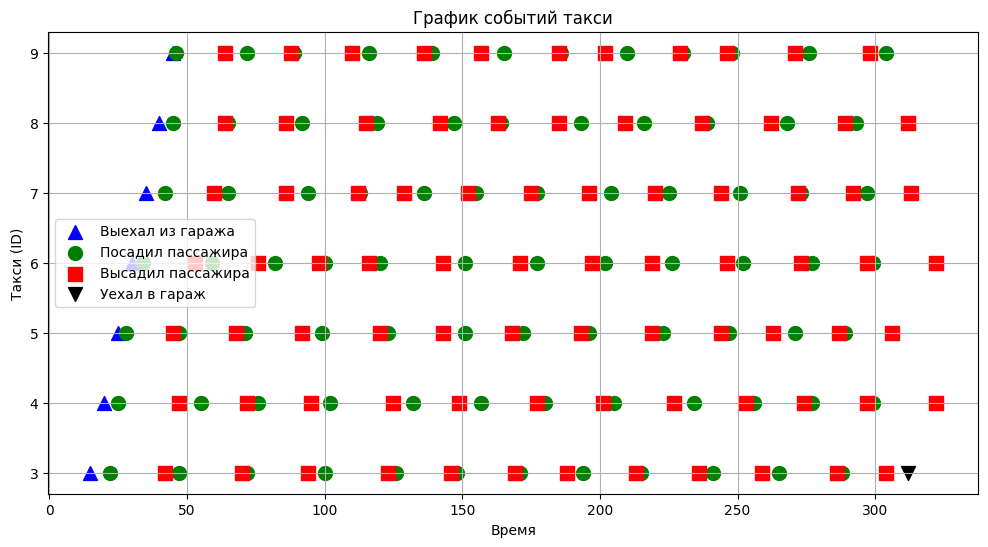

In [14]:
# import matplotlib.pyplot as plt

# xy=[(m[0],(m[1]+1)) for m in eventslog]

# plt.figure()
# plt.scatter([p[0] for p in xy],[p[1] for p in xy], c='g', marker='v', s=9)
# plt.xlabel("время"); plt.ylabel("Такси")
# plt.show()


# Visualization with different markers
import matplotlib.pyplot as plt

# Separate events by type
pickups = [m for m in eventslog if m.состояние == 'посадил пассажира']
dropoffs = [m for m in eventslog if m.состояние == 'высадил пассажира']
garage_out = [m for m in eventslog if m.состояние.startswith('выехал из гаража')]
garage_in = [m for m in eventslog if m.состояние.startswith('уехал в гараж')]

plt.figure(figsize=(12, 6))

# Plot different events with different markers/colors
plt.scatter([m.время for m in garage_out], [m.ID for m in garage_out], 
            c='blue', marker='^', s=100, label='Выехал из гаража')
plt.scatter([m.время for m in pickups], [m.ID for m in pickups], 
            c='green', marker='o', s=100, label='Посадил пассажира')
plt.scatter([m.время for m in dropoffs], [m.ID for m in dropoffs], 
            c='red', marker='s', s=100, label='Высадил пассажира')
plt.scatter([m.время for m in garage_in], [m.ID for m in garage_in], 
            c='black', marker='v', s=100, label='Уехал в гараж')

plt.xlabel("Время")
plt.ylabel("Такси (ID)")
plt.title("График событий такси")
plt.legend()
plt.grid(True)
plt.show()